<a href="https://colab.research.google.com/github/TakashiSato/colaboratory/blob/master/NonLinearOptimalControl/Algorithm2.1_SteepestDescentMethod_2link_IK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import numpy as np
import sympy
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def custom_latex_printer(expr, **options):
    from IPython.display import Math, HTML
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-AMS_CHTML"
    javascript(content="""window.MathJax = {
        tex2jax: {
            inlineMath: [ ['$','$'] ],
            processEscapes: true
        }
        };""")
    javascript(url=url)
    return latex(expr, **options)
init_printing(use_latex="mathjax", latex_printer=custom_latex_printer)

## Robot Arm Class Definition

In [78]:
class DHParameter():
  def __init__(self, link_size):
    self.link_size = link_size
    self.a  = sympy.zeros(self.link_size, 1)
    self.alpha  = sympy.zeros(self.link_size, 1)
    self.d = sympy.zeros(self.link_size, 1)
    self.theta = sympy.zeros(self.link_size, 1)
    for i in range(self.link_size):
      self.a[i], self.alpha[i], self.d[i], self.theta[i] = sympy.var(['a_'+str(i), 'alpha_'+str(i), 'd_' + str(i+1), 'theta_'+str(i+1)])

  def get_symbols(self):
      return self.a, self.alpha, self.d, self.theta

class RobotArm():
  def __init__(self, joint_size):
    self.joint_size = joint_size
    self.link_size = joint_size + 1
    # create symbols
    self.dh = DHParameter(self.link_size)
    a, alpha, d, theta = self.dh.get_symbols()

    # create HT-matrix
    self.T_i = []
    self.T_base = []
    for i in range(self.link_size):
      T = Matrix([[cos(theta[i]), -sin(theta[i]), 0, a[i]], [cos(alpha[i])*sin(theta[i]), cos(alpha[i])*cos(theta[i]), -sin(alpha[i]), -d[i]*sin(alpha[i])], [sin(alpha[i])*sin(theta[i]), sin(alpha[i])*cos(theta[i]), cos(alpha[i]), d[i]*cos(alpha[i])],[0,0,0,1]])
      self.T_i.append(T)
      self.T_base.append(self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i])

  def get_dh_symbols(self):
    return self.dh.get_symbols()

  def set_dh_parameters(self, dh_params):
    for i in range(self.link_size):
        self.T_i[i] = self.T_i[i].subs(dh_params)
        self.T_base[i] = self.T_i[0] if i == 0  else self.T_base[i-1] * self.T_i[i]
        # self.T_base[i] = self.T_base[i].subs(dh_params)

  def forward_kinematics(self, q):
    T_base = []
    if len(q) != self.joint_size:
      print('invalid joint length')
    np.append(q, 0)
    subs_dict = dict(zip(self.dh.theta, q))
    for i in range(self.link_size):
      T_base.append(self.T_base[i].subs(subs_dict))
    return T_base

  def draw(self, q, coordinate='xy'):
      T_base = []
      T_base.append(sympy.eye(4,4))
      T_base.extend(self.forward_kinematics(q))
      for i in range(len(T_base)-1):
        X = [T_base[i][0,3], T_base[i+1][0,3]]
        Y = [T_base[i][1,3], T_base[i+1][1,3]]
        Z = [T_base[i][2,3], T_base[i+1][2,3]]
        if coordinate == 'xy':
          plt.plot(X, Y, '-o')
        elif coordinate == 'xz':
          plt.plot(X, Z, '-o')
        elif coordinate == 'yz':
          plt.plot(Y, Z, '-o')
      plt.axes().set_aspect('equal', 'datalim')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


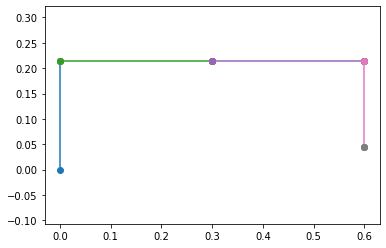

In [79]:
# joint_size = 2    
# robot = RobotArm(joint_size)
# a, alpha, d, theta = robot.get_dh_symbols()
# robot.set_dh_parameters({
#     a[0]: 0,     alpha[0]: 0, d[0]: 0,
#     a[1]: 0.5, alpha[1]: 0, d[1]: 0,
#     a[2]: 0.5, alpha[2]: 0, d[2]: 0, theta[2]: 0,
# })
# robot.forward_kinematics([0, np.pi/2])
# robot.draw([np.pi/2, np.pi/4])

joint_size = 7
robot = RobotArm(joint_size)
a, alpha, d, theta = robot.get_dh_symbols()
robot.set_dh_parameters({
    a[0]: 0, alpha[0]: 0,               d[0]: 0.215,
    a[1]: 0, alpha[1]: -np.pi/2, d[1]: 0,
    a[2]: 0, alpha[2]: +np.pi/2, d[2]: 0.300,
    a[3]: 0, alpha[3]: -np.pi/2,  d[3]: 0,
    a[4]: 0, alpha[4]: +np.pi/2, d[4]: 0.300,
    a[5]: 0, alpha[5]: -np.pi/2,  d[5]: 0,
    a[6]: 0, alpha[6]: +np.pi/2, d[6]: 0.170,
    a[7]: 0, alpha[7]: 0,                d[7]: 0, theta[7]: 0,
})
# robot.T_base[2]
# robot.T_base[2][0:3,3]
# robot.draw([0,0, np.pi/4,np.pi/2],'yz')
# robot.forward_kinematics([0,np.pi/2,0,0,0,0,0])[2]
# robot.forward_kinematics([0,np.pi/2])
# robot.draw([np.pi/2,np.pi/2], 'xz')?
robot.draw([0,np.pi/2, 0,0,0,np.pi/2,0], 'xz')

In [54]:
X = Matrix([[x], [y]])

## 評価関数

In [6]:
g = X - FK

In [7]:
f = g.T * g
f

<IPython.core.display.Javascript object>

⎡                                   2                                      2⎤
⎣(-l₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)  + (-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ + θ₂) + x) ⎦

## 勾配ベクトル

In [8]:
rf_rt = Matrix([diff(f, theta_1), diff(f, theta_2)]).T
rf_rt

<IPython.core.display.Javascript object>

[(2⋅l₁⋅sin(θ₁) + 2⋅l₂⋅sin(θ₁ + θ₂))⋅(-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ + θ₂) + x) + (-2⋅
l₁⋅cos(θ₁) - 2⋅l₂⋅cos(θ₁ + θ₂))⋅(-l₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)  -2⋅l₂⋅(-l
₁⋅sin(θ₁) - l₂⋅sin(θ₁ + θ₂) + y)⋅cos(θ₁ + θ₂) + 2⋅l₂⋅(-l₁⋅cos(θ₁) - l₂⋅cos(θ₁ 
+ θ₂) + x)⋅sin(θ₁ + θ₂)]

## 再急降下法

In [9]:
def steepest_descent_method(xd, yd, link1_length, link2_length, init_theta_1, init_theta_2, epsilon):

  params = ((l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd))
  FK_s = FK.subs(params)
  # FK_s = FK.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
  rf_rt_s = rf_rt.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
  f_s = f.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd)])
 
  def compute_slope_vector(theta):
    return rf_rt_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])

  def compute_descent_vector(theta):  
    return -compute_slope_vector(theta).T

  def compute_forward_kinematics(theta):  
    return FK_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])

  def compute_eval_value(theta):  
    return f_s.subs([(theta_1, theta[0]), (theta_2, theta[1])])[0]

  # def compute_slope_vector(theta):
  #   return rf_rt.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])

  # def compute_descent_vector(theta):  
  #   return -compute_slope_vector(theta).T

  # def compute_forward_kinematics(theta):  
  #   return FK.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])

  # def compute_eval_value(theta):  
  #   return f.subs([(l_1, link1_length), (l_2, link2_length), (x, xd), (y, yd), (theta_1, theta[0]), (theta_2, theta[1])])[0]

  theta = Matrix([init_theta_1, init_theta_2])
  for i in range(100):
    slope = compute_slope_vector(theta)
    slope_norm = slope.norm()
    if slope_norm < epsilon:
      break
    s = compute_descent_vector(theta)

    # 直線探索
    eval_min = sys.float_info.max
    alpha_star = 0.
    for alpha in np.linspace(0.0, 1.0, 10):
      temp_theta = theta + alpha * s
      eval_value = compute_eval_value(temp_theta)
      if eval_value < eval_min:
        eval_min = eval_value
        alpha_star = alpha
    theta = theta + alpha_star * s
    fk = compute_forward_kinematics(theta)

    print('[%d] FK: [%f, %f], theta: [%f, %f], alpha: %f, s: [%f, %f], eval_value: %f, slope_norm: %f' % (i, fk[0], fk[1], theta[0], theta[1], min_alpha, s[0], s[1], eval_min, slope_norm))

  print('==== Result ====')
  theta = np.array(theta).astype(np.float64)
  print('[%d] FK: [%f, %f], theta: [%f, %f (rad): %f, %f (deg)], eval_value: %f, slope_norm: %f' % (i, fk[0], fk[1], theta[0], theta[1], np.degrees(theta[0]), np.degrees(theta[1]), compute_eval_value(theta), slope_norm))
  return theta

In [136]:
class OptimizationResult():
  def __init__(self):
    self.x_symbols = None
    self.f_symbols = None
    self.slope_symbols = None
    self.x_star = []
    self.x0_log = []
    self.eval_log = []

  def record_log(self, x0, eval):
    self.x0_log.append(x0)
    self.eval_log.append(eval)

  def set_result(self, f_symbols, slope_symbols, x_symbols, x_star):
    self.f_symbols = f_symbols
    self.slope_symbols = slope_symbols
    self.x_symbols = x_symbols
    self.x_star = np.array(x_star).astype(np.float64).reshape(1,-1)[0]

In [145]:
def steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-4, max_iteration=100):
  ret = OptimizationResult()

  # slope_symbols = sympy.tensor.array.derive_by_array(f_symbols, x_symbols)
  slope_symbols = sympy.zeros(len(x_symbols),1)
  for i in range(len(x_symbols)):
    slope_symbols[i] = diff(f_symbols, x_symbols[i])

  ret.record_log(x0, f_symbols.subs(list(zip(x_symbols, x0))))
  for i in range(max_iteration):
    slope =  slope_symbols.subs(list(zip(x_symbols, x0)))
    if slope.norm() < epsilon:
      break
    s = -slope

    # 直線探索
    eval_min = sys.float_info.max
    alpha_star = 0.
    for alpha in np.linspace(0.0, 5.0, 10):
      x_temp = x0 + alpha * s
      eval_value = f_symbols.subs(list(zip(x_symbols, x_temp)))
      if eval_value < eval_min:
        eval_min = eval_value
        alpha_star = alpha
    x0 = x0 + alpha_star * s
    ret.record_log(x0, eval_min)

    if i % 10 == 0:
      print(i, x0, eval_value, slope.norm())
  ret.set_result(f_symbols, slope_symbols, x_symbols, x0)     
  return ret

## 具体値計算

0 Matrix([[1.11111111111111], [0.555555555555556]]) 3.45457191701209 2.23606797749979
10 Matrix([[0.819511712408481], [0.206670607195566]]) 0.524004028192627 0.117300560058161
20 Matrix([[0.845193030651724], [0.103019271627837]]) 0.0830736414922575 0.0174488418243553
30 Matrix([[0.874052482254465], [0.0481468517371225]]) 0.0834046536206975 0.0130164198410834
40 Matrix([[0.884785190472378], [0.0235395192670118]]) 0.0792519768400755 0.00484229877034916
50 Matrix([[0.890358291561434], [0.0115472463756261]]) 0.0788052699673032 0.00195408922886406


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


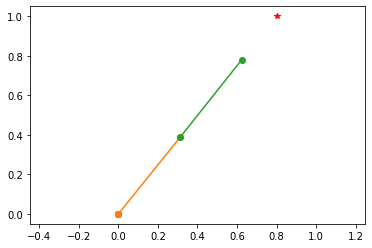

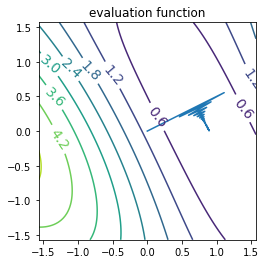

In [149]:
# create robot arm
robot = RobotArm(2)
a, alpha, d, theta = robot.get_dh_symbols()
robot.set_dh_parameters({
    a[0]: 0,     alpha[0]: 0, d[0]: 0,
    a[1]: 0.5, alpha[1]: 0, d[1]: 0,
    a[2]: 0.5, alpha[2]: 0, d[2]: 0, theta[2]: 0,
})
# robot.forward_kinematics([0, np.pi/2])
# robot.draw([np.pi/2, np.pi/4])

# problem settings
x0 = Matrix([0, 0])
xd = Matrix([0.8, 1.0])
ee_pose = robot.T_base[2][0:2,3]
f_symbols = Matrix((xd - ee_pose).T * (xd - ee_pose))[0]
x_symbols = Matrix(theta[0:2])

def plot_result(result):
  robot.draw(result.x_star)
  plt.plot(xd[0], xd[1], 'r*')

  plt.figure()
  t1 = t2 = np.linspace(-np.pi/2, np.pi/2, 100)
  f_func = sympy.lambdify(result.x_symbols, result.f_symbols, 'numpy') 
  slope_func = sympy.lambdify(result.x_symbols, result.slope_symbols, 'numpy') 
  X, Y = np.meshgrid(t1, t2)
  Z = f_func(X, Y)
  cont = plt.contour(X, Y, Z)
  cont.clabel(fmt='%1.1f', fontsize=14)
  x0_ = []
  y0_ = []
  for x0 in result.x0_log:
    x0_.append(x0[0])
    y0_.append(x0[1])
  plt.plot(x0_, y0_, '-')
  plt.axes().set_aspect('equal')
  plt.title('evaluation function')
  # plt.pcolormesh(X,Y,Z,cmap='cool')

# solve problem
result = steepest_descent_method(f_symbols, x_symbols, x0, epsilon=1e-3, max_iteration=100)
# print(result.x_symbols)
plot_result(result)
# result.x0_log
# np.array(result.x0_log).astype(np.float64)